In [56]:
import cv2
import numpy as np;
import matplotlib.pyplot as plt;
from mpl_toolkits import mplot3d
%matplotlib inline

# ICP Alignment

## Stereo Class for Easy Use

In [57]:
stereo_data = cv2.FileStorage('stereo_cameras.xaml', cv2.FileStorage_READ)
K1 = stereo_data.getNode('K1').mat()
K2 = stereo_data.getNode('K2').mat()

D1 = stereo_data.getNode('D1').mat()
D2 = stereo_data.getNode('D2').mat()


R1 = stereo_data.getNode('R1').mat()
R2 = stereo_data.getNode('R2').mat()

P1 = stereo_data.getNode('P1').mat()
P2 = stereo_data.getNode('P2').mat()

In [58]:
class StereoVision:
    def __init__(self,K1,K2,D1,D2,R1,R2,P1,P2,h=480,w=1280,baseline=60, minDisp=0, numDisp=16, blockSize=13):
        self.lmapx, self.lmapy = cv2.initUndistortRectifyMap(K1,D1,R1,P1, (w//2,int(h)), cv2.CV_32FC1)
        self.rmapx, self.rmapy = cv2.initUndistortRectifyMap(K2,D2,R2,P2, (w//2,int(h)), cv2.CV_32FC1)
        
        self.stereoL = cv2.StereoSGBM_create(minDisp, numDisp,blockSize=blockSize);
        self.stereoR = cv2.ximgproc.createRightMatcher(self.stereoL);
        
        self.wlsFilter = cv2.ximgproc.createDisparityWLSFilter(self.stereoL);
        self.wlsFilter.setLambda(8000)
        self.wlsFilter.setSigmaColor(2.0)
        
        self.KL = K1
        self.KR = K2
        self.baseline = baseline
        
        self.numDisp = numDisp
        self.minDisp = minDisp
        
    def rectify(self,imL,imR):
        im1L = cv2.remap(imL, self.lmapx, self.lmapy, cv2.INTER_LINEAR)
        im1R = cv2.remap(imR, self.rmapx, self.rmapy, cv2.INTER_LINEAR)
        return im1L, im1R
    def disparityMap(self,imL,imR):
        grayimL = cv2.cvtColor(imL, cv2.COLOR_BGR2GRAY)
        grayimR = cv2.cvtColor(imR, cv2.COLOR_BGR2GRAY)
        
        dispL = self.stereoL.compute(grayimL,grayimR)
        dispR = self.stereoR.compute(grayimR,grayimL)
        disp = self.wlsFilter.filter(dispL,grayimL,grayimR,dispR) / 16.0
        return disp
    def getNormDisp(self,disp):
        return (disp - self.minDisp) / self.numDisp
    def triangulate(self,disp):
        fx = self.KL[0,0]
        fy = self.KL[1,1]
        favg = (fx+fy)/2

        cx = self.KL[0,2]
        cy = self.KL[1,2]
        c = np.array([[cx,cy]]).T
        
        xx,yy = np.meshgrid(np.arange(disp.shape[1]), np.arange(disp.shape[0]))
        dp_flatten = disp.flatten()
        xx = xx.flatten()
        yy = yy.flatten()
        mask = (dp_flatten > 0)
        
        pix_coords = np.vstack((xx,yy))
        pix_valid = pix_coords[:,mask]
        
        pix_transform = (pix_coords[:,mask] - c) * (self.baseline / (dp_flatten[mask]))
        z = (self.baseline * favg) / dp_flatten[mask]
        
        x = pix_transform[0,:]
        y = pix_transform[1,:]
        return np.vstack((x,y,z))

In [59]:
from skimage.measure import ransac
from skimage.transform import AffineTransform

In [60]:
class Point8_pipeline:
    def __init__(self, K):
        self.orb = cv2.ORB_create()
        self.K = K
    def featureMatching(self, im1,im2):
        

        kp1, des1 = self.orb.detectAndCompute(im1, None)
        kp2, des2 = self.orb.detectAndCompute(im2, None)

        des1 = np.float32(des1)
        des2 = np.float32(des2)

        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        src_pts = np.float32([kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)

        #ransac
        model, inliers = ransac( (src_pts, dst_pts), 
                                AffineTransform, min_samples=4, residual_threshold=8, max_trials=40)


        return src_pts[inliers], dst_pts[inliers]
    def eight_point(self, src_pts, dst_pts):
        assert src_pts.shape[0] == 2
        assert dst_pts.shape[0] == 2
        assert src_pts.shape[1] == dst_pts.shape[1]
        assert src_pts.shape[1] >= 8

        ones = np.ones(shape=src_pts.shape[1])

        #projective coords
        start = np.vstack((src_pts,ones))
        end = np.vstack((dst_pts,ones))

        end_x = start[0,:] * end
        end_y = start[1,:] * end
        end_1 = start[2,:] * end

        A = np.vstack((end_x,end_y,end_1)).T # create homogenous matrix

        ATA = A.T@A

        U,S,V = np.linalg.svd(A)

        #e = V[:,np.argmin(S)]
        e = V[np.argmin(S),:]

        F = e.reshape(3,3)

        return F
    def triangulate(self, ptsL, ptsR, R0, t0):
        R = R0.T
        t = -R0.T@t0

        qL = ptsL.copy()
        qR = ptsR.copy()
        fx = self.K[0,0]
        fy = self.K[1,1]
        cx = self.K[0,2]
        cy = self.K[1,2]
        c = np.array([[cx,cy]]).T

        qL = qL - c
        qL[0,:] = qL[0,:] / fx
        qL[1,:] = qL[1,:] / fy

        qR = qR - c
        qR[0,:] = qR[0,:] / fx
        qR[1,:] = qR[1,:] / fy

        qL = np.vstack( (qL,np.ones(qL.shape[1])) )
        qR = np.vstack( (qR,np.ones(qR.shape[1])) )

        Rlql = qL
        Rrqr = (R @ qR) * -1
        b = t    

        zhatL = np.zeros(shape=(1,ptsL.shape[1]))
        zhatR = np.zeros(shape=(1,ptsR.shape[1]))
        for i in range(ptsL.shape[1]):
            R_lidx = Rlql[:,i].reshape(3,1)
            R_ridx = Rrqr[:,i].reshape(3,1)
            A = np.hstack((R_lidx,R_ridx))

            zhat = np.linalg.lstsq(A,b,rcond=None)[0]
            zhatL[:,i] = zhat[0]
            zhatR[:,i] = zhat[1]
        PL = zhatL * qL
        PR = zhatR * qR

        P1 = PL
        P2 = R @ PR + t
        pts3 = (P1+P2)/2
        return pts3
    
    def decomposeE(self, F, src_pts, dst_pts):
        #cheirality condition checking to decompose essential matrix
        E = self.K.T @ F @ self.K # fundamental
        
        U,S,VT = np.linalg.svd(E)
        s = (S[0] + S[1])/2
        S = np.array([[s,0,0], [0,s,0], [0,0,0]])
        E = U @ S @ VT
        
        W = np.array([[0, -1, 0],
                      [1, 0, 0],
                      [0, 0, 1]])

        U,S,VT = np.linalg.svd(E)

        R1 = U @ W @ VT
        R2 = U @ W.T @ VT
        R3 = U @ W @ VT
        R4 = U @ W.T @ VT

        C1 = U[:,2].reshape(3,1)
        C2 = -U[:,2].reshape(3,1)
        C3 = U[:,2].reshape(3,1)
        C4 = U[:,2].reshape(3,1)

        #check rotation determinants
        if np.linalg.det(R1) < 0:
            R1 = -R1
            C1 = -C1
        if np.linalg.det(R2) < 0:
            R2 = -R2
            C2 = -C2
        if np.linalg.det(R3) < 0:
            R3 = -R3
            C3 = -C3
        if np.linalg.det(R4) < 0:
            R4 = -R4
            C4 = -C4
        pts3_1 = self.triangulate(src_pts, dst_pts, R1, C1)
        pts3_2 = self.triangulate(src_pts, dst_pts, R2, C2)
        pts3_3 = self.triangulate(src_pts, dst_pts, R3, C3)
        pts3_4 = self.triangulate(src_pts, dst_pts, R4, C4)

        z_1 = R1[2,:]@(pts3_1 - C1)
        z_2 = R2[2,:]@(pts3_2 - C2)
        z_3 = R3[2,:]@(pts3_3 - C3)
        z_4 = R4[2,:]@(pts3_4 - C4)

        s1 = (z_1 > 0).sum()
        s2 = (z_2 > 0).sum()
        s3 = (z_3 > 0).sum()
        s4 = (z_4 > 0).sum()

        max_sum = max([s1,s2,s3,s4])
        if max_sum == s1:
            return R1.T, -R1.T@C1
        elif max_sum==s2:
            return R2.T, -R2.T@C2
        elif max_sum==s3:
            return R3.T, -R3.T@C3
        else:
            return R4.T, -R4.T@C4

In [61]:
def create_output(vertices, colors, filename):
	vertices = np.hstack([vertices,colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

## Load im1

In [62]:
stereo = StereoVision(K1,K2,D1,D2,R1,R2,P1,P2)
point8_pipe = Point8_pipeline(K1)

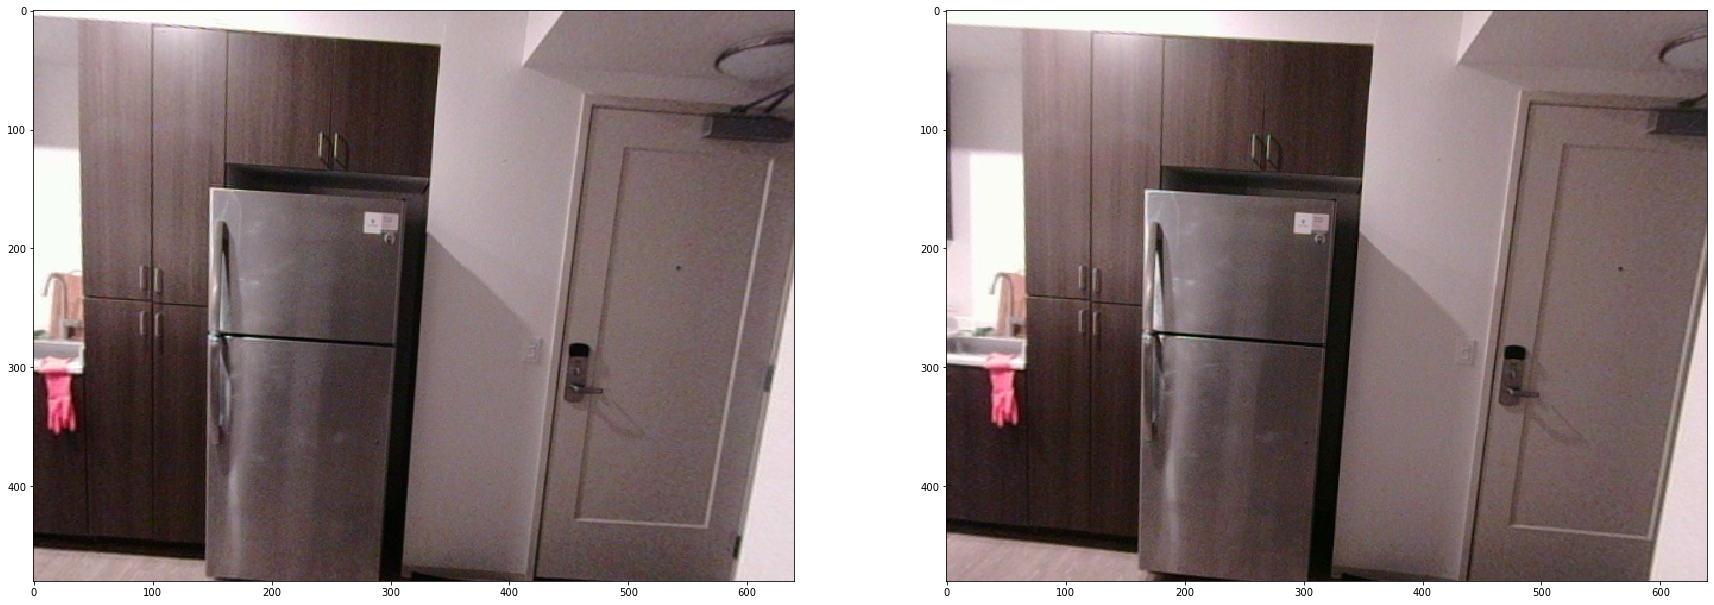

In [63]:
im1 = cv2.imread('test_im/im0.jpg')
h,w,_ = im1.shape
im1L = im1[:,:w]
im1R = im1[:,w//2:]

im1L, im1R = stereo.rectify(im1L,im1R)

disp1 = stereo.disparityMap(im1L,im1R)
pts31 = stereo.triangulate(disp1)

plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.imshow(im1L[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(im1R[:,:,::-1])
plt.show()

In [64]:
cv2.imwrite('imL.jpg', im1L)
cv2.imwrite('imR.jpg', im1R)

True

In [65]:
pts31.shape

(3, 295870)

## load im2

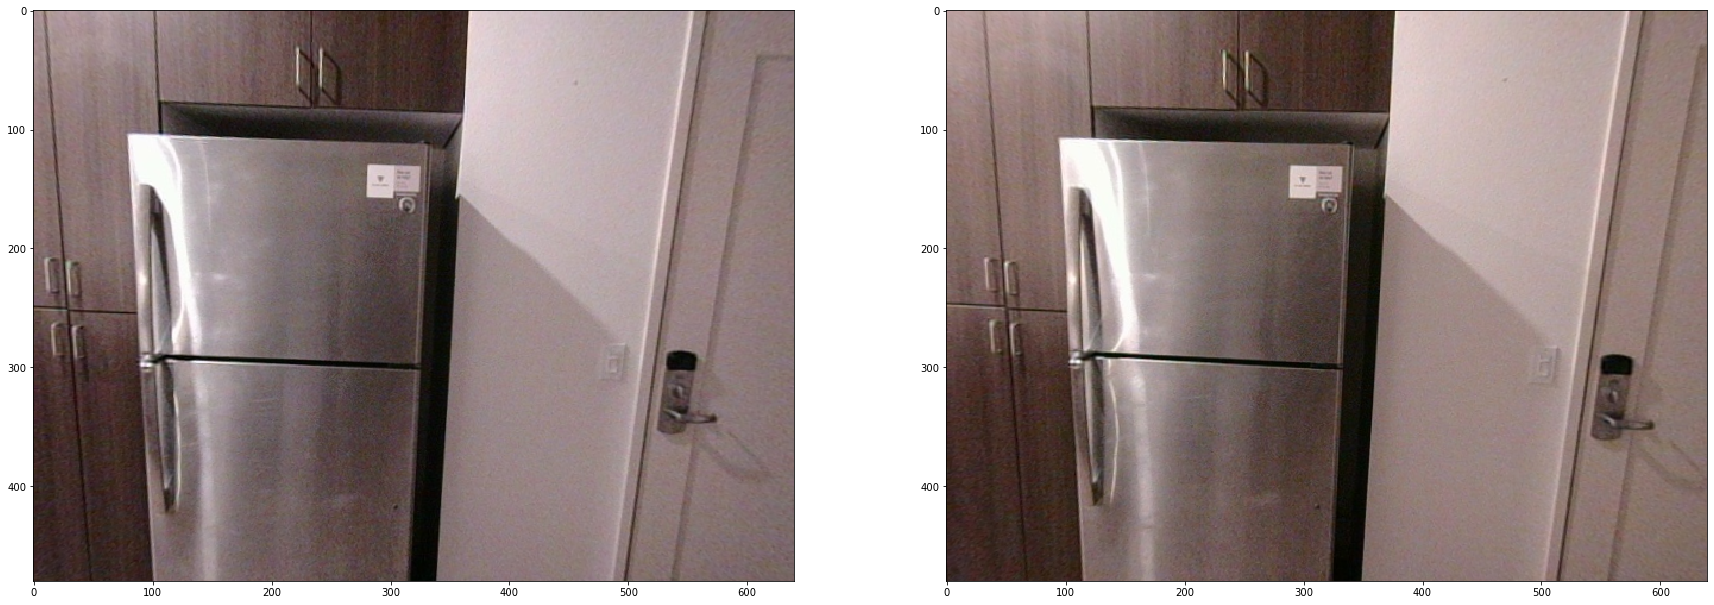

In [66]:
im2 = cv2.imread('test_im/im1.jpg')
h,w,_ = im2.shape
im2L = im2[:,:w]
im2R = im2[:,w//2:]

im2L, im2R = stereo.rectify(im2L,im2R)

disp2 = stereo.disparityMap(im2L,im2R)
pts32 = stereo.triangulate(disp2)

plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.imshow(im2L[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(im2R[:,:,::-1])
plt.show()

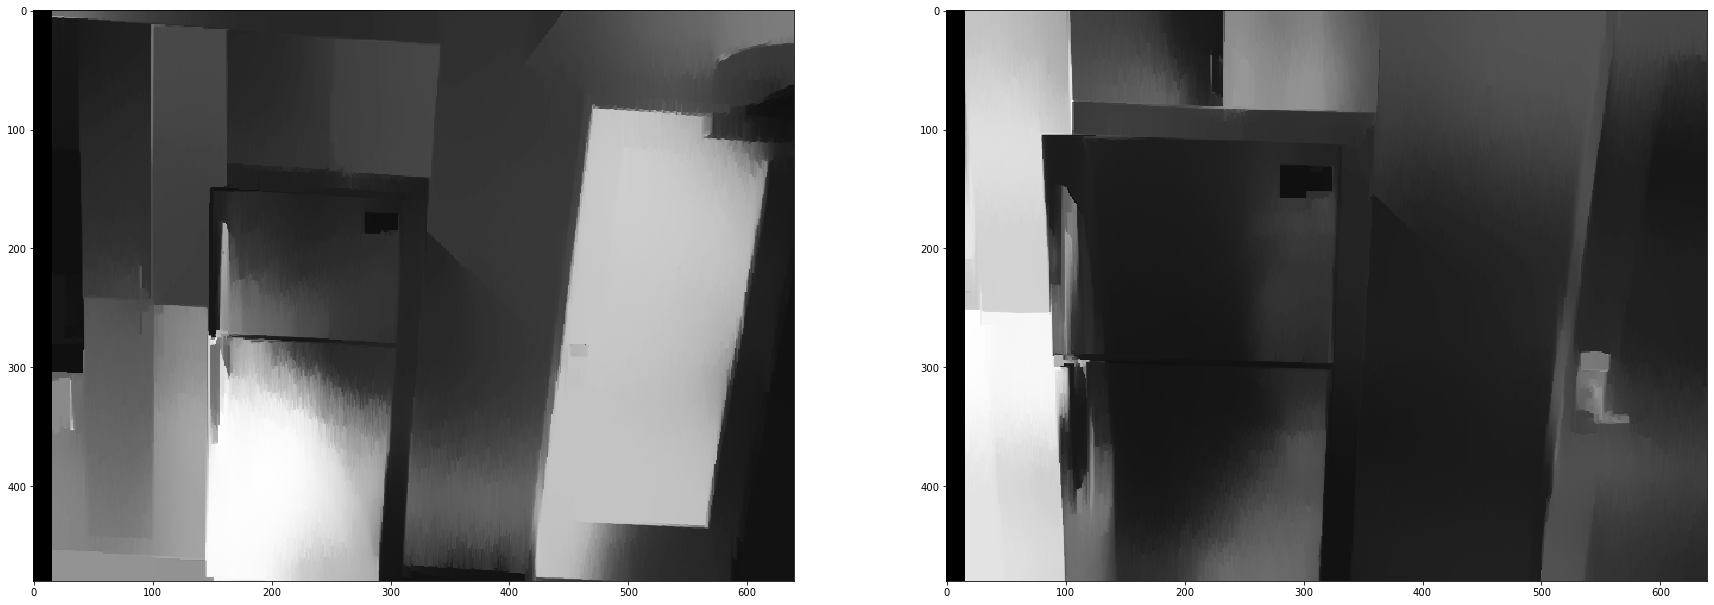

In [67]:
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.imshow(stereo.getNormDisp(disp1), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(stereo.getNormDisp(disp2), cmap='gray')
plt.show()

## Estimate R,t

In [68]:
src_pts, dst_pts = point8_pipe.featureMatching(im1L, im2L)
F = point8_pipe.eight_point(src_pts.T,dst_pts.T)
R,t = point8_pipe.decomposeE(F,src_pts.T,dst_pts.T)

In [69]:
pts32_transform = R @ pts32 + t

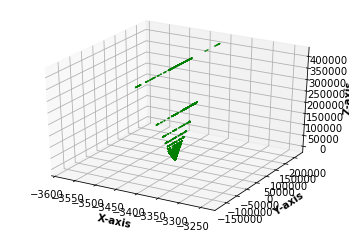

In [70]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pts31[0,:1],pts31[1,:], pts31[2,:],color='green', s=0.1)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

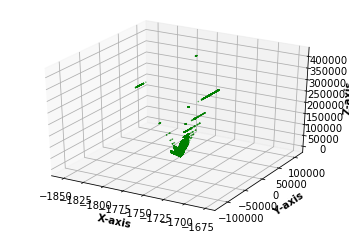

In [71]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pts32[0,:1],pts32[1,:], pts32[2,:],color='green', s=0.1)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

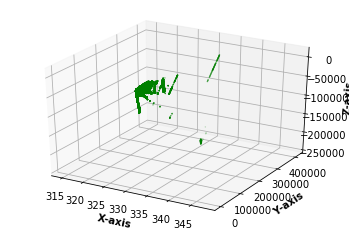

In [72]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pts32_transform[0,:1],pts32_transform[1,:], pts32_transform[2,:],color='green', s=0.1)
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')
plt.show()

In [51]:
colors1 = cv2.cvtColor(im1L, cv2.COLOR_BGR2RGB)
color_map1 = colors1[(disp1>0)].reshape(-1,3)

colors2 = cv2.cvtColor(im2L, cv2.COLOR_BGR2RGB)
color_map2 = colors2[(disp2>0)].reshape(-1,3)

In [52]:
pts3 = np.hstack( (pts31,pts32_transform) )

color_map = np.vstack((color_map1,color_map2))

In [53]:
create_output(pts31.T, color_map1, 'icp_test1.ply')

In [54]:
def visual(R,t,ax,size=1):
    x = np.array([[size,0,0,1]]).T
    y = np.array([[0,size,0,1]]).T
    z = np.array([[0,0,size,1]]).T
    ze = np.array([[0,0,0,1]]).T
    
    transform = np.hstack((R,t))
    
    xt = transform @ x
    yt = transform @ y
    zt = transform @ z
    zet = transform @ ze
    
    
    vecA = xt - zet
    vecB = yt - zet
    vecC = zt - zet
    assert (vecA.T @ vecB)[0] <1e-5, f'nonzero dot {(vecA.T @ vecB)[0]}'
    assert (vecA.T @ vecC)[0] <1e-5, f'nonzero dot {(vecA.T @ vecC)[0]}'
    assert (vecB.T @ vecC)[0] <1e-5, f'nonzero dot {(vecB.T @ vecC)[0]}'
    
    pts = np.hstack((xt,yt,zt,zet))
    ax.scatter(pts[0,:], pts[1,:], pts[2,:])
    xvec = np.hstack((zet,xt))
    yvec = np.hstack((zet,yt))
    zvec = np.hstack((zet,zt))
    ax.plot(xvec[0,:], xvec[1,:], xvec[2,:],c='blue')
    ax.plot(yvec[0,:], yvec[1,:], yvec[2,:],c='red')
    ax.plot(zvec[0,:], zvec[1,:], zvec[2,:],c='green')

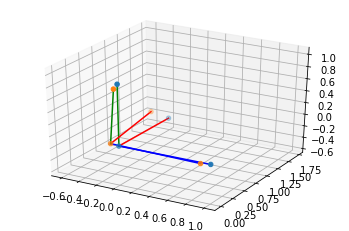

In [55]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
visual(np.eye(3), np.array([[0,0,0]]).T, ax)
visual(R,t,ax)
plt.show()